In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2022-02-11 19:47:39.492350: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2022-02-11 19:47:40.293426: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2022-02-11 19:47:40.339634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-11 19:47:40.339682: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-11 19:47:40.344284: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-11 19:47:40.344354: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2022-02-11 19:47:40.346390: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [2]:
from os import environ
dataset = environ['dataset']
print(dataset)

redd_gen_GASF_13m_100S5X5A4934_R82_80-20


In [3]:
#my defs 
from modules.models import  LSTM_3D_V56, CNN_V56,LSTM_BI_V56
from modules.tools import my_print, plot_confusion_matrix_norm, get_data,get_data_split, evaluate_model, create_tl_model
from modules.HDF5ImageGenerator import HDF5ImageGenerator

In [4]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42_80-20"
file_name = "refit_gen_GASF_60m_300S0X_15A157030N_R12_80-20-V1"
file_name = environ["dataset"]
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [5]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)

['fridge/freezer', 'electric furnace', 'light', 'microwave', 'sockets']
{0: 1.3540308747855918, 1: 2.1335135135135137, 2: 0.5634546752319771, 3: 3.5881818181818184, 4: 0.5749453750910415}
 
Tests 
fridge/freezer test: 146 train: 583
electric furnace test: 92 train: 370
light test: 351 train: 1401
microwave test: 55 train: 220
sockets test: 343 train: 1373


In [6]:
def select_model(learn_type):
    
    if learn_type == "CNN":
        model = CNN_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "LSTM":
        model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    if learn_type == "BI_LSTM":
        model = LSTM_BI_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

    return model
              

In [7]:
path_save = path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']
path_save_nb = path_save+"_out.ipynb"
path_save_log = path_save+"_out_log2.txt"

In [8]:
from keras.callbacks import LambdaCallback
#path_log= path+'/experiment_automation/output/'+environ['learn_type']+'/'+dataset.split("_")[0]+"/"+environ['train_type']+"/"+dataset.split("_")[0]+"_"+environ['seed']+"_"+environ['tl_datasets']+"_log.txt"
txt_log = open(path_save+"_log.txt", mode='wt', buffering=1)
txt_log.write("file created! \n")

save_op_callback = LambdaCallback(
  on_epoch_end = lambda epoch, logs: txt_log.write(
    str({'epoch': epoch, 'loss': logs['loss'],'acc': logs['accuracy']}) + '\n'),
                                                           
)

In [9]:
print(path_save_nb)

/workspace/notebooks/experiment_automation/output/BI_LSTM/redd/TL/redd_82_refit, iawe, eco, ukdale_out.ipynb


In [10]:
# rm $path_save_log

In [11]:
# %%capture cap 

# with open(path_save_log,"wt") as f:
#     f.write(cap.stdout)
    
# print("out capture..")

In [12]:
# %%capture cap --no-stderr


if environ['train_type'] == "BB":

    #define generator
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=int(environ['batch_size']),
        num_classes=num_of_classes,
        mode="train",
        )
    
    model = select_model(environ['learn_type'])
    
    txt_log.write("fitting BB model: \n")
    
    model.fit(
        train_gen,
        verbose=2,
        epochs=int(environ['epochs']),
        class_weight=d_class_weights,
        callbacks = [save_op_callback],
    )
    
    txt_log.write("finished fitting BB model: \n")

    evaluate_model(model,x_test,y_test,appliances)
    
    if environ['save_model']=="True":

        path_model_save = path+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]
        model.save(path_model_save)
        txt_log.write("model saved to:"+"/models/"+environ['learn_type']+"/"+dataset.split("_")[0]+"_"+dataset.split("_R")[1][0:2]+" \n")
        
        
# with open(path_save+"_out_log.txt" as f:
#     f.write(cap.stdout)


In [13]:
#model = keras.models.load_model(path_model1)
# model_used = model

In [14]:
# evaluate_model(model,x_test,y_test,appliances)

using dataset data redd training on model refit seed 82
reading data, printing stats: 
['fridge/freezer', 'electric furnace', 'light', 'microwave', 'sockets']
{0: 1.3540308747855918, 1: 2.1335135135135137, 2: 0.5634546752319771, 3: 3.5881818181818184, 4: 0.5749453750910415}
 
Tests 
fridge/freezer test: 146 train: 583
electric furnace test: 92 train: 370
light test: 351 train: 1401
microwave test: 55 train: 220
sockets test: 343 train: 1373
loading model
compling TL model..


2022-02-11 19:47:41.047565: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-11 19:47:41.047897: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2022-02-11 19:47:41.047951: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2022-02-11 19:47:41.412137: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-02-11 19:47:41.412171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2022-02-11 19:47:41.412177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2022-02-11 19:47:41.412761: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Normal way
[0 1 2 3 4 5 6 7 8 9]
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-02-11 19:47:49.198274: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-11 19:47:49.216597: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz


Epoch 1/50


2022-02-11 19:47:52.715945: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2022-02-11 19:47:53.199069: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2022-02-11 19:47:53.679145: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2022-02-11 19:47:54.086318: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


124/124 - 8s - loss: 0.9742 - accuracy: 0.5680
Epoch 2/50
124/124 - 3s - loss: 0.6241 - accuracy: 0.6924
Epoch 3/50
124/124 - 3s - loss: 0.5752 - accuracy: 0.7112
Epoch 4/50
124/124 - 3s - loss: 0.5470 - accuracy: 0.7175
Epoch 5/50
124/124 - 3s - loss: 0.5277 - accuracy: 0.7216
Epoch 6/50
124/124 - 3s - loss: 0.5072 - accuracy: 0.7299
Epoch 7/50
124/124 - 3s - loss: 0.4890 - accuracy: 0.7357
Epoch 8/50
124/124 - 3s - loss: 0.4772 - accuracy: 0.7423
Epoch 9/50
124/124 - 3s - loss: 0.4794 - accuracy: 0.7403
Epoch 10/50
124/124 - 3s - loss: 0.4743 - accuracy: 0.7393
Epoch 11/50
124/124 - 3s - loss: 0.4598 - accuracy: 0.7548
Epoch 12/50
124/124 - 3s - loss: 0.4531 - accuracy: 0.7540
Epoch 13/50
124/124 - 3s - loss: 0.4567 - accuracy: 0.7489
Epoch 14/50
124/124 - 3s - loss: 0.4418 - accuracy: 0.7570
Epoch 15/50
124/124 - 3s - loss: 0.4560 - accuracy: 0.7520
Epoch 16/50
124/124 - 3s - loss: 0.4531 - accuracy: 0.7499
Epoch 17/50
124/124 - 3s - loss: 0.4308 - accuracy: 0.7570
Epoch 18/50
124/1

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
124/124 - 6s - loss: 1.2930 - accuracy: 0.4677
Epoch 2/50
124/124 - 3s - loss: 1.0462 - accuracy: 0.5282
Epoch 3/50
124/124 - 3s - loss: 0.9392 - accuracy: 0.5409
Epoch 4/50
124/124 - 3s - loss: 0.8902 - accuracy: 0.5478
Epoch 5/50
124/124 - 3s - loss: 0.8804 - accuracy: 0.5599
Epoch 6/50
124/124 - 3s - loss: 0.8498 - accuracy: 0.5739
Epoch 7/50
124/124 - 3s - loss: 0.8337 - accuracy: 0.5911
Epoch 8/50
124/124 - 3s - loss: 0.8161 - accuracy: 0.5865
Epoch 9/50
124/124 - 3s - loss: 0.8386 - accuracy: 0.5842
Epoch 10/50
124/124 - 3s - loss: 0.8066 - accuracy: 0.5982
Epoch 11/50
124/124 - 3s - loss: 0.8015 - accuracy: 0.5903
Epoch 12/50
124/124 - 3s - loss: 0.7995 - accuracy: 0.5865
Epoch 13/50
124/124 - 3s - loss: 0.8089 - accuracy: 0.5911
Epoch 14/50
124/124 - 3s - loss: 0.7904 - accuracy: 0.5999
Epoch 15/50
124/124 - 3s - loss: 0.7783 - accuracy: 0.6043
Epoch 16/50
124/124 - 3s - loss: 0.7788 - accuracy: 0.6045
Epoch 17/50
124/124 - 3s - loss:

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
124/124 - 6s - loss: 0.8918 - accuracy: 0.5650
Epoch 2/50
124/124 - 3s - loss: 0.6716 - accuracy: 0.6805
Epoch 3/50
124/124 - 3s - loss: 0.6008 - accuracy: 0.7059
Epoch 4/50
124/124 - 3s - loss: 0.5832 - accuracy: 0.7114
Epoch 5/50
124/124 - 3s - loss: 0.5639 - accuracy: 0.7165
Epoch 6/50
124/124 - 3s - loss: 0.5411 - accuracy: 0.7256
Epoch 7/50
124/124 - 3s - loss: 0.5372 - accuracy: 0.7319
Epoch 8/50
124/124 - 3s - loss: 0.5217 - accuracy: 0.7319
Epoch 9/50
124/124 - 3s - loss: 0.5084 - accuracy: 0.7357
Epoch 10/50
124/124 - 3s - loss: 0.5081 - accuracy: 0.7337
Epoch 11/50
124/124 - 3s - loss: 0.4908 - accuracy: 0.7446
Epoch 12/50
124/124 - 3s - loss: 0.4877 - accuracy: 0.7423
Epoch 13/50
124/124 - 3s - loss: 0.4723 - accuracy: 0.7441
Epoch 14/50
124/124 - 3s - loss: 0.4834 - accuracy: 0.7512
Epoch 15/50
124/124 - 3s - loss: 0.4752 - accuracy: 0.7504
Epoch 16/50
124/124 - 3s - loss: 0.4718 - accuracy: 0.7459
Epoch 17/50
124/124 - 3s - loss:

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Normal way
[0 1 2 3 4 5 6 7 8 9]
Epoch 1/50
124/124 - 6s - loss: 0.9679 - accuracy: 0.5797
Epoch 2/50
124/124 - 3s - loss: 0.7308 - accuracy: 0.6369
Epoch 3/50
124/124 - 3s - loss: 0.6653 - accuracy: 0.6696
Epoch 4/50
124/124 - 3s - loss: 0.6572 - accuracy: 0.6681
Epoch 5/50
124/124 - 3s - loss: 0.6257 - accuracy: 0.6841
Epoch 6/50
124/124 - 3s - loss: 0.6015 - accuracy: 0.6950
Epoch 7/50
124/124 - 3s - loss: 0.5959 - accuracy: 0.6988
Epoch 8/50
124/124 - 3s - loss: 0.5847 - accuracy: 0.7026
Epoch 9/50
124/124 - 3s - loss: 0.5783 - accuracy: 0.7048
Epoch 10/50
124/124 - 3s - loss: 0.5654 - accuracy: 0.6965
Epoch 11/50
124/124 - 3s - loss: 0.5405 - accuracy: 0.7178
Epoch 12/50
124/124 - 3s - loss: 0.5290 - accuracy: 0.7208
Epoch 13/50
124/124 - 3s - loss: 0.5394 - accuracy: 0.7218
Epoch 14/50
124/124 - 3s - loss: 0.5480 - accuracy: 0.7203
Epoch 15/50
124/124 - 3s - loss: 0.5306 - accuracy: 0.7233
Epoch 16/50
124/124 - 3s - loss: 0.5249 - accuracy: 0.7241
Epoch 17/50
124/124 - 3s - loss:

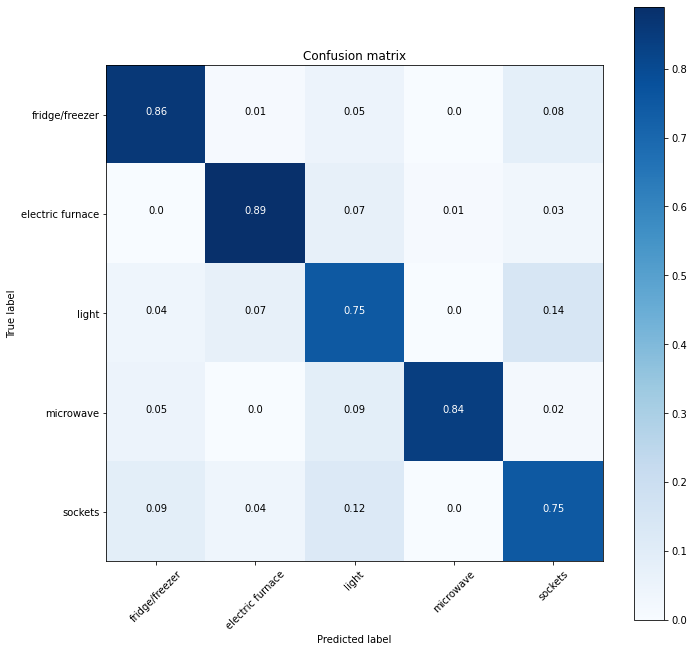

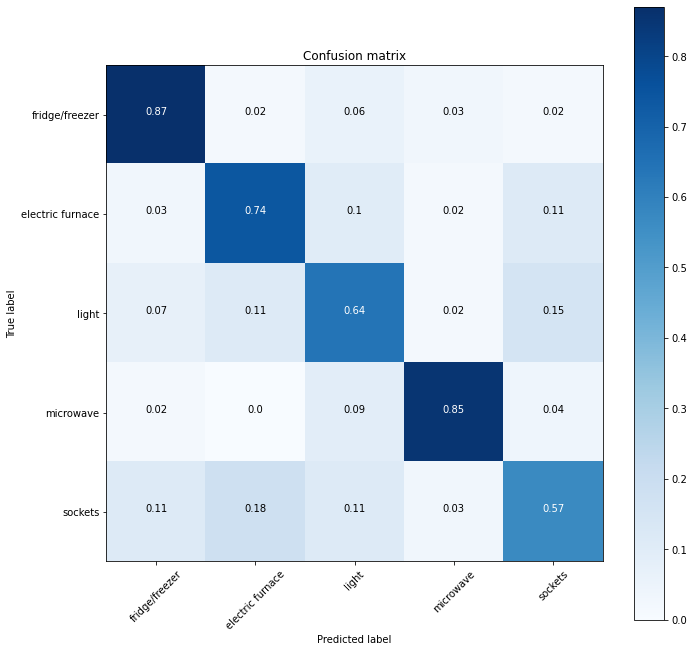

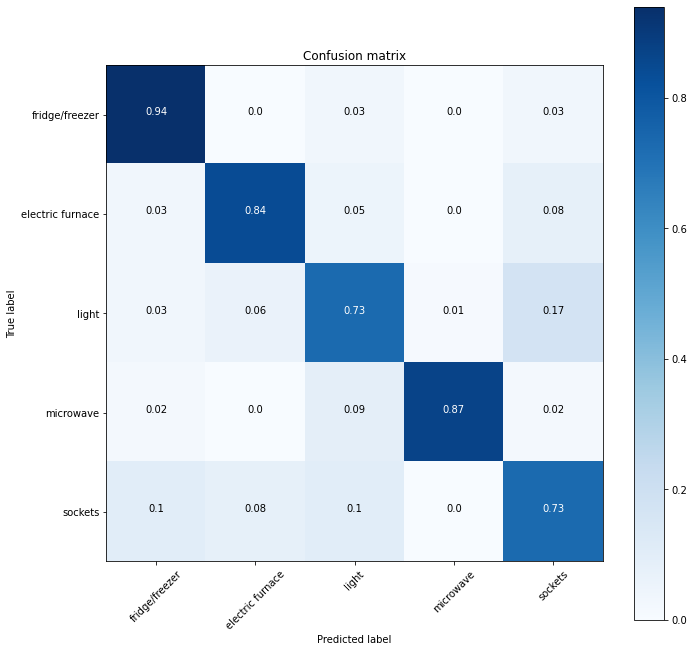

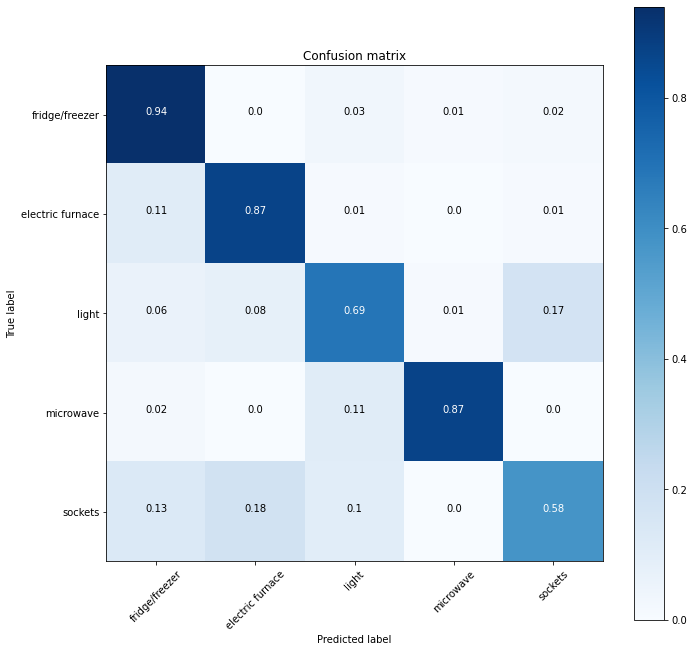

In [15]:
# datasets =[
#     "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
# ]

if environ['train_type'] == "TL": 
    models = environ['tl_datasets'].replace(" ","").split(",")
    #model = ["base"]
    
    for model in models:
    
        file_name = dataset
        
        datasetTL = model
        
        seed = dataset.split("_R")[1][0:2]
        
        print("using dataset data",dataset.split("_")[0],"training on model",model,"seed",environ['seed'])
        txt_log.write("starting "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        tf.keras.backend.clear_session()


        #read the file
        path = str(pathlib.Path().resolve())
        path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
        file = h5py.File(path_data,"r+")


        print("reading data, printing stats: ")
        x_test,y_test,d_class_weights,num_of_classes,appliances = get_data(file)
        print("loading model")
        
        model_seed = 42
        model_used = create_tl_model(model,environ['learn_type'],model_seed,path,num_of_classes)
                
        train_gen = HDF5ImageGenerator(
            src= path_data,
            X_key="data/train/gaf",
            y_key="labels/train/gaf",
            classes_key="appliances/classes",
            labels_encoding="hot",
            shuffle=True,
            batch_size=int(environ['batch_size']),
            num_classes=num_of_classes,
            mode="train",
            )

        model_used.fit(
            train_gen,
            verbose=2,
            epochs=int(environ['epochs']),
            class_weight=d_class_weights,
            callbacks = [save_op_callback]
            #workers = 6,
        )
        
        txt_log.write("finished "+dataset.split("_")[0]+" training on model "+model+" seed "+environ['seed']+"\n")


        evaluate_model(model_used,x_test,y_test,appliances)
        



        #del model_used



In [16]:
txt_log.close()